## Import library

In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# Cuda to used Rtx 2060
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Augmentation and PreProccessing of Training data

In [15]:
img_width=256; img_height=256
batch_size=16
TRAINING_DIR = '../weather_pred/Data/training/'
train_datagen = ImageDataGenerator(rescale = 1/255.0,
                                   rotation_range=30,
                                   zoom_range=0.4,
                                   horizontal_flip=True   )
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=(img_height, img_width))

Found 1274 images belonging to 5 classes.


## Preproccessing of Validation data

In [16]:
VALIDATION_DIR = '../weather_pred/Data/validation/'
validation_datagen = ImageDataGenerator(rescale = 1/255.0)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              target_size=(img_height, img_width)
                                                             )

Found 226 images belonging to 5 classes.


In [17]:
callbacks = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
best_model_file = 'CNN_best_weights_256_with_Aug.h5'
best_model = ModelCheckpoint(best_model_file, monitor='val_acc', verbose = 1, save_best_only = True)

## Model Structure

In [19]:
model = tf.keras.models.Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(256, (3, 3), activation='relu'),
    Conv2D(256, (3, 3), activation='relu'),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 conv2d_12 (Conv2D)          (None, 58, 58, 64)       

In [20]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics =['accuracy'])
history = model.fit_generator(train_generator,
                              epochs=30,
                              verbose=1,
                              validation_data=validation_generator,
                              callbacks = [best_model, callbacks]
                              )

C:\Users\Kerillos\AppData\Local\Temp\ipykernel_18724\1041231039.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/30
80/80 [==============================] - 19s 225ms/step - loss: 1.5736 - accuracy: 0.2276 - val_loss: 1.6052 - val_accuracy: 0.2345
Epoch 2/30
80/80 [==============================] - 19s 231ms/step - loss: 1.4557 - accuracy: 0.3383 - val_loss: 1.1704 - val_accuracy: 0.5133
Epoch 3/30
80/80 [==============================] - 19s 236ms/step - loss: 1.1806 - accuracy: 0.4937 - val_loss: 1.1318 - val_accuracy: 0.4336
Epoch 4/30
80/80 [==============================] - 21s 256ms/step - loss: 1.1265 - accuracy: 0.5181 - val_loss: 0.9332 - val_accuracy: 0.5487
Epoch 5/30
80/80 [==============================] - 20s 243ms/step - loss: 1.0171 - accuracy: 0.5228 - val_loss: 0.8966 - val_accuracy: 0.5575
Epoch 6/30
80/80 [==============================] - 20s 250ms/step - loss: 0.9548 - accuracy: 0.5628 - val_loss: 0.9530 - val_accuracy: 0.5265
Epoch 7/30
80/80 [==============================] - 18s 229ms/step - loss: 0.9898 - accuracy: 0.5518 - val_loss: 0.8844 - val_accuracy: 0.5796

Epoch 28/30
80/80 [==============================] - 18s 224ms/step - loss: 0.7673 - accuracy: 0.6852 - val_loss: 0.8169 - val_accuracy: 0.6637
Epoch 29/30
80/80 [==============================] - 18s 224ms/step - loss: 0.7374 - accuracy: 0.6837 - val_loss: 0.6928 - val_accuracy: 0.7522
Epoch 30/30
80/80 [==============================] - 19s 231ms/step - loss: 0.7816 - accuracy: 0.6727 - val_loss: 0.7961 - val_accuracy: 0.6726


## Save Model

In [21]:
target_dir = '../weather_pred/'
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
model.save(target_dir + 'CNN_model_256_with_Aug.h5')
model.save_weights(target_dir + 'CNN_weights_256_with_Aug.h5')

In [22]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

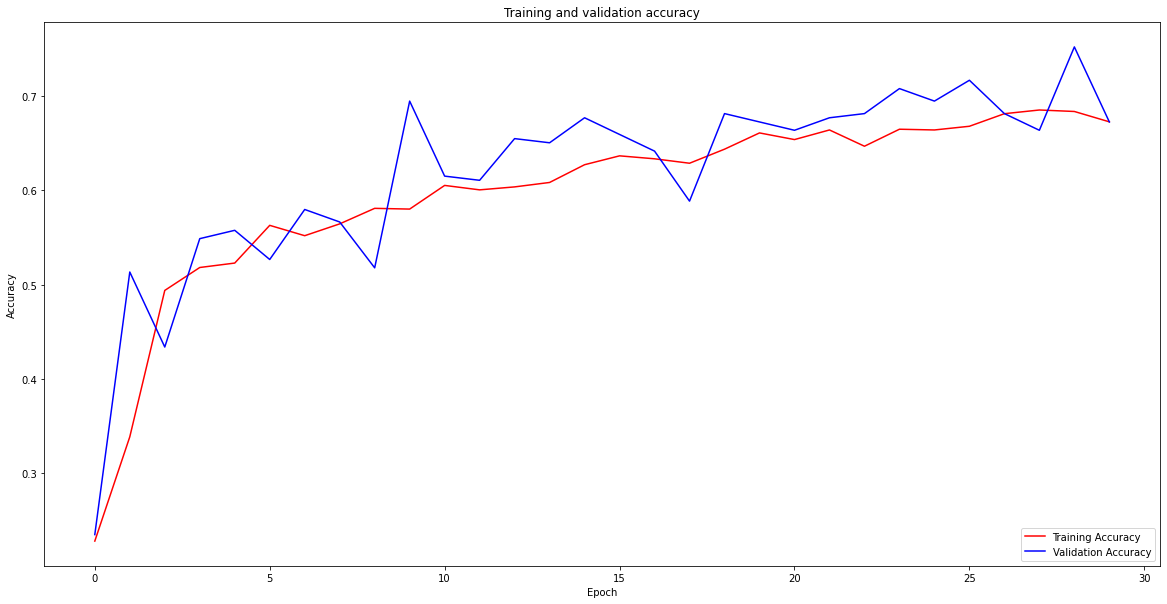

In [23]:
fig = plt.figure(figsize=(20,10))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()
fig.savefig('Accuracy_curve_CNN_256_without_Aug.jpg')

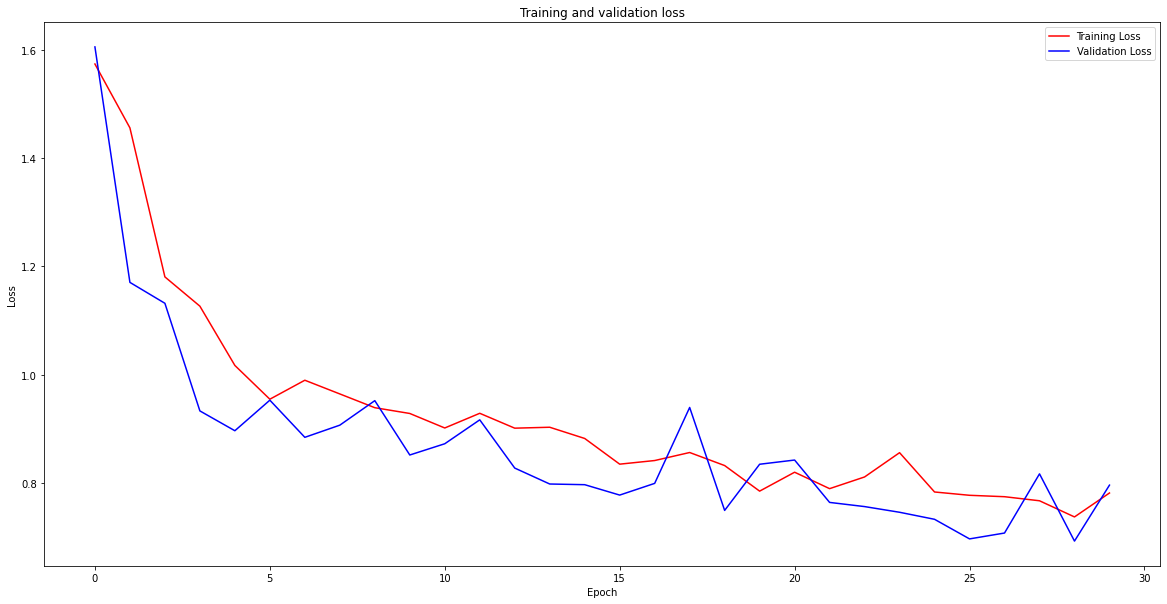

In [24]:
fig2 = plt.figure(figsize=(20,10))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')
fig2.savefig('Loss_curve_CNN_256_without_Aug.jpg')
